In [2]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import shap
import sklearn
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("../src/helper-functions"))
import tree_shap

In [3]:
Tree = DecisionTreeRegressor()

In [4]:
target = [-10] * 10 + [10] * 5 + [5] * 20 + [14] * 5
cat_1 = [1] * 10 + [0] * 30
x = [60] * 5 + [45] * 30 +  [50] * 5
cat_2 = [1] * 15 + [0] * 25
data = pd.DataFrame({"cat_1": cat_1,
                     "cat_2": cat_2,
                     "x": x,
                     "target": target})

In [5]:
Tree.fit(data.values[:,:-1], data.values[:,-1])
explainer_tree = shap.TreeExplainer(Tree)
input_shap = np.array([0,1,60])
print(f"Shap values from the fitted explainer: {explainer_tree.shap_values(input_shap)}")
print(f"Theoretical Shap values: {np.array([191/36, 25/18, 155/36])}")
input_shap = np.array([[0,1,60], [1,0,40]])

Shap values from the fitted explainer: [5.30555556 1.38888889 4.30555556]
Theoretical Shap values: [5.30555556 1.38888889 4.30555556]


In [6]:
Tree.tree_.n_node_samples


array([40, 30, 25, 20,  5,  5, 10], dtype=int64)

In [7]:
explainer_tree_shap = shap.TreeExplainer(Tree)
explainer_tree_shap.shap_values(input_shap)

array([[  5.30555556,   1.38888889,   4.30555556],
       [-12.14583333,  -0.33333333,  -0.52083333]])

In [8]:
explainer_tree_cat = tree_shap.tree_cat_explainer(Tree)
explainer_tree_cat.shap_values(input_shap)

array([[  5.30555556,   1.38888889,   4.30555556],
       [-12.14583333,  -0.33333333,  -0.52083333]])

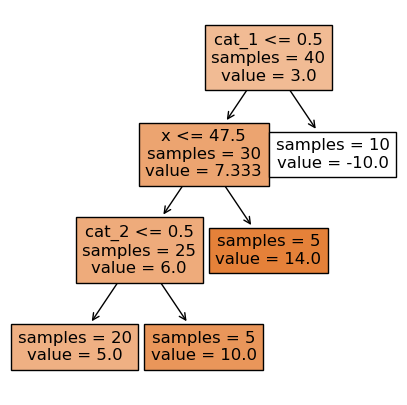

In [9]:
fig, ax = plt.subplots(figsize = (5,5))
plot_tree1 = plot_tree(Tree, ax = ax, filled=True, feature_names = ["cat_1", "cat_2", "x"], impurity = False)
plt.show()

In [10]:
X, y = make_classification(n_samples=1000, n_features=7,
                           n_informative=4, n_redundant=0,
                           random_state=0, shuffle=False)
import create_categories
X_df = pd.DataFrame(X, columns= ["X_" + str(i) for i in range(X.shape[1])])
X_df["X_0"] = create_categories.transform_num_to_cat(X[:, 0], "new_0", 5)
X_df["X_1"] = create_categories.transform_num_to_cat(X[:, 1], "new_1", 5)
X_cat = X_df.copy()
X_cat = pd.get_dummies(X_cat, columns= ["X_0", "X_1"], drop_first= True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.33, random_state=42)
rf = RandomForestClassifier(n_estimators=20, random_state= 123).fit(X_train,y_train)
print(accuracy_score(y_test, rf.predict(X_test)))
print(precision_score(y_test, rf.predict(X_test)))
print(recall_score(y_test, rf.predict(X_test)))

0.803030303030303
0.8300653594771242
0.7650602409638554


In [11]:
explain = shap.TreeExplainer(rf)
shap_val = explain.shap_values(X_test)
feature_groups = [i for i in range(5)] + [[5,6,7,8]] + [[9,10,11,12]]
shap_sum = tree_shap.sum_cat_shap(shap_val, feature_groups, n_classes=2)

In [12]:
# explain_cat = tree_shap.tree_cat_explainer(rf, feature_groups = feature_groups)
# shap_cat = explain_cat.shap_values(X_test)

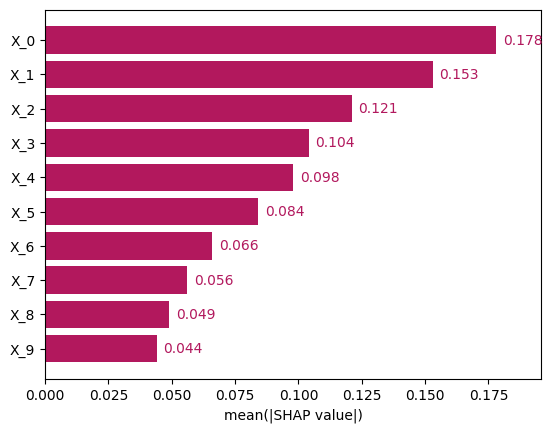

In [14]:
fig, ax = plt.subplots(1)
tree_shap.bar_plot(tree_shap.normalise_absolute_shap_value(shap_val[:, :, 0]), ax =ax)
plt.show()

In [25]:
import pickle
path_folder = "../outputs/comparison-shap/data/"

path_pkl = os.path.abspath(path_folder + f"nb_var_cat_{3}.pkl")
with open(path_pkl, "rb") as f:
    results = pickle.load(f)
print(abs(results["iteration 0"]["shap_cat_classif_train"]).mean(axis = 0))
print(abs(results["iteration 0"]["shap_classif_train"]).mean(axis = 0))

[0.13264733 0.09678061 0.03161349 0.0283823  0.0550654  0.06457427
 0.08129364]
[0.13203539 0.09595057 0.03171749 0.02788695 0.05625986 0.06454556
 0.08137271]


In [26]:
from sklearn.metrics import mean_absolute_error as mae
error = 0
for i in range(20):
    error =+ 1/20 * mae(tree_shap.normalise_absolute_shap_value(results[f"iteration {i}"]["shap_cat_classif_test"]), 
        tree_shap.normalise_absolute_shap_value(results[f"iteration {i}"]["shap_classif_test"]))
error

0.0002054761904761905

In [34]:
mae = 0
for iter in range(20):
    mae += 1/20 * results[f"iteration {iter}"]["accuracy"]
print(mae)

0.7474999999999999


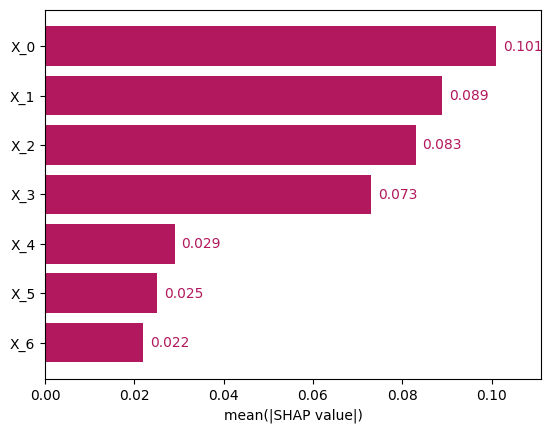

In [13]:
fig, ax = plt.subplots(1)
tree_shap.bar_plot(shap_cat[:, :, 0], ax= ax)
plt.show()

In [17]:
np.array([3.65432,5.23456]).round(3)

array([3.654, 5.235])

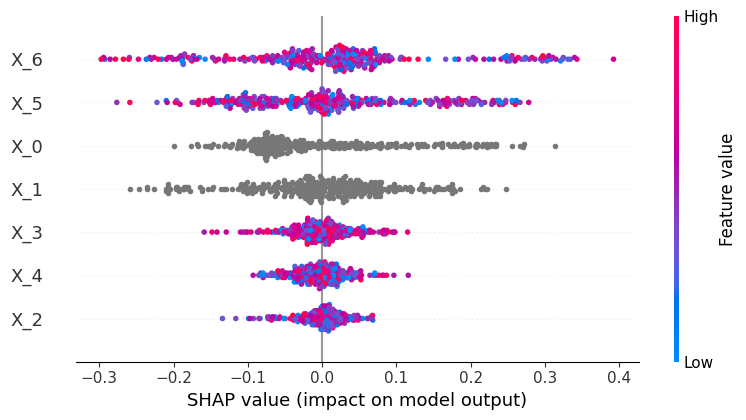

In [ ]:
shap.summary_plot(
    shap_sum[:,:,1], X_df.head(330))

In [86]:
abs(shap_cat[:,:,0])

array([0.02191899, 0.02907092, 0.02498041])

In [84]:
abs(shap_sum[:,:,0]).mean(axis = 0)

array([0.0845341 , 0.06992767, 0.02141361, 0.02877541, 0.0251432 ,
       0.09025616, 0.0980264 ])

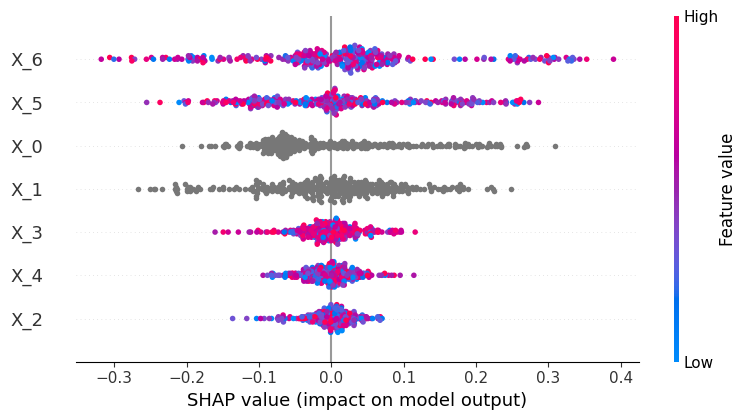

In [79]:
shap.summary_plot(
    shap_cat[:,:,1], X_df.head(330))

In [74]:
shap_sum.shape

(330, 7, 2)

In [75]:
X_df.head(330).shape

(330, 13)

-0.0003310487861528453
0.0018882163491071508
-0.0006960420839787441
0.0014537084172871906
0.0027749178963514397
-0.012212019799792348
-0.01709980345369921


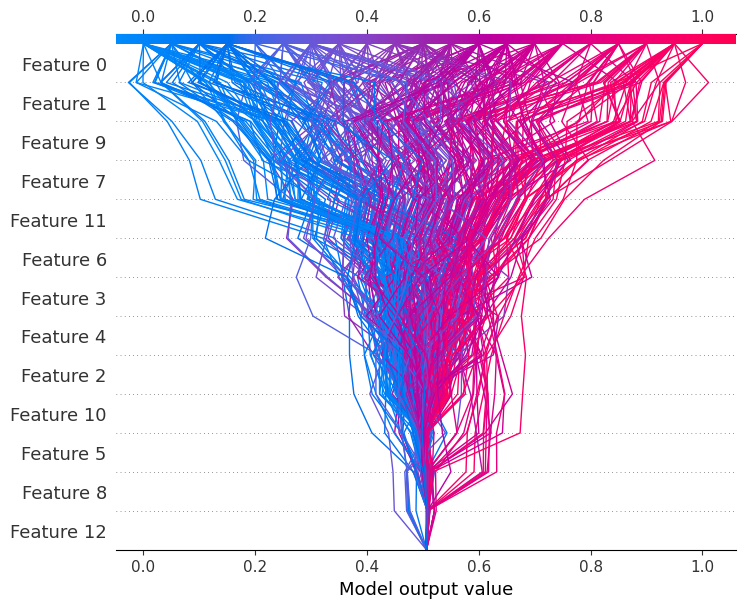

In [45]:
for i in range(shap_sum.shape[1]):
    print(shap_sum[:,i,0].mean())
shap.decision_plot(explain.expected_value[0], shap_val[:,:,0])

In [44]:
for i in range(shap_cat.shape[1]):
    print(shap_cat[:,i,0].mean())

-0.0007341980261658083
0.0015239872590276028
-0.0007615936984853488
0.0015864502597087477
0.0028013376391425528
-0.011653517916275315
-0.016984536977829826


In [46]:
X_test.columns

Index(['X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_0_new_0_cat_2', 'X_0_new_0_cat_3',
       'X_0_new_0_cat_4', 'X_0_new_0_cat_5', 'X_1_new_1_cat_2',
       'X_1_new_1_cat_3', 'X_1_new_1_cat_4', 'X_1_new_1_cat_5'],
      dtype='object')

In [48]:
shap_sum[0]

array([[ 0.10693526, -0.10693526],
       [ 0.05945656, -0.05945656],
       [-0.01495108,  0.01495108],
       [-0.07639104,  0.07639104],
       [-0.01173185,  0.01173185],
       [-0.16792853,  0.16792853],
       [ 0.09826739, -0.09826739]])

In [49]:
shap_val[0]

array([[ 0.10693526, -0.10693526],
       [ 0.05945656, -0.05945656],
       [-0.01495108,  0.01495108],
       [-0.07639104,  0.07639104],
       [-0.01173185,  0.01173185],
       [-0.01359633,  0.01359633],
       [-0.0774151 ,  0.0774151 ],
       [-0.07592908,  0.07592908],
       [-0.00098803,  0.00098803],
       [ 0.05984266, -0.05984266],
       [ 0.015222  , -0.015222  ],
       [ 0.01929814, -0.01929814],
       [ 0.00390458, -0.00390458]])